In [664]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [665]:
df=pd.read_csv('DM2425_ABCDEats_DATASET.csv',delimiter=',')

In [666]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31888 entries, 0 to 31887
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               31888 non-null  object 
 1   customer_region           31888 non-null  object 
 2   customer_age              31161 non-null  float64
 3   vendor_count              31888 non-null  int64  
 4   product_count             31888 non-null  int64  
 5   is_chain                  31888 non-null  int64  
 6   first_order               31782 non-null  float64
 7   last_order                31888 non-null  int64  
 8   last_promo                31888 non-null  object 
 9   payment_method            31888 non-null  object 
 10  CUI_American              31888 non-null  float64
 11  CUI_Asian                 31888 non-null  float64
 12  CUI_Beverages             31888 non-null  float64
 13  CUI_Cafe                  31888 non-null  float64
 14  CUI_Ch

# Drop Dublicates

We need to eliminate duplicates to prevent further issues, especially with the index setting

In [667]:
df.duplicated().sum()

np.int64(13)

In [668]:
df=df.drop_duplicates()
# Count the number of remaining duplicate rows in the DataFrame after dropping duplicates
df.duplicated().sum()

np.int64(0)

# Set costumer_id as the index

In [669]:
df.set_index('customer_id', inplace=True)

## Fixing variables

**customer_age**

Fill missing values with median

In [670]:
df['customer_age'].isna().sum()

np.int64(727)

In [671]:
df['customer_age'] = df['customer_age'].fillna(df['customer_age'].median())
df['customer_age'].isna().sum()

np.int64(0)

**costumer_region**

Replace the value of '-' with 'Unknown' to enhance the interpretation of the feature

In [672]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('-', np.nan)

In [673]:
mode_value = df['customer_region'].mode()[0]
df['customer_region'] = df['customer_region'].fillna(mode_value)

In [674]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('8550', 'Others')

In [675]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('2440', 'Others')

In [676]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('4140', 'Others')

In [677]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('8370', 'Others')

In [678]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('2490', 'Others')

In [679]:
df['customer_region'].value_counts()

customer_region
8670      10203
4660       9550
2360       8829
Others     3293
Name: count, dtype: int64

**product_count**

There is an extreme product count value with '92ced2dcb9' index, so we will transform it into a high value

In [680]:
df.loc['92ced2dcb9','product_count']=100

**first_order**

Fill missing values with median

In [681]:
df['first_order'] = df['first_order'].fillna(df['first_order'].median())

**last_promo**

Replace the value of '-' with 'no_promotion_used' to enhance the interpretation of the feature

In [682]:
df['last_promo'] = df['last_promo'].replace('-', 'no_promotion_used')

**HR_0**

Drop the column labeled "HR_0" because it contains only zeros.

In [683]:
df.drop(columns=['HR_0'], inplace=True)

#Fixing inconsistencies

Eliminate rows where there are inconsistencies

In [684]:
df['sum_HR']=df['HR_1']+df['HR_2']+df['HR_3']+df['HR_4']+df['HR_5']+df['HR_6']+df['HR_7']+df['HR_8']+df['HR_9']+df['HR_10']+df['HR_11']+df['HR_12']+df['HR_13']+df['HR_14']+df['HR_15']+df['HR_16']+df['HR_17']+df['HR_18']+df['HR_19']+df['HR_20']+df['HR_21']+df['HR_22']+df['HR_23']
df['sum_DOW']=df['DOW_0']+df['DOW_1']+df['DOW_2']+df['DOW_3']+df['DOW_4']+df['DOW_5']+df['DOW_6']
df['inc_0']=(df['sum_HR']!=df['sum_DOW'])
df['inc_2']=(df['product_count']==0)
df = df.loc[~(df['inc_0'] | df['inc_2'])]
df = df.drop(columns=['sum_HR', 'sum_DOW', 'inc_0', 'inc_2'])

# New variables

**Total_Spent**

In [685]:
cuisine = [col for col in df.columns if col.startswith('CUI_')]

In [686]:
df['Total_Spent']=df[cuisine].sum(axis=1)

Deal with extreme outliers

In [687]:
df = df.drop('92ced2dcb9', axis=0)
df.loc['249ba584d3','CUI_Asian']=500
df.loc['8d65421423','CUI_Japanese']=590
df['Total_Spent']=df[cuisine].sum(axis=1)

**Order_Count**

In [606]:
df['order_count']=df['DOW_0']+df['DOW_1']+df['DOW_2']+df['DOW_3']+df['DOW_4']+df['DOW_5']+df['DOW_6']

**Diversity_Cuisine**

In [607]:
df['Diversity_Cuisine'] = (df[cuisine] > 0).sum(axis=1)
df['Diversity_Cuisine'] = df['order_count']/df['Diversity_Cuisine']

**Costumer_time**

In [608]:
df['costumer_time']=df['last_order']-df['first_order']

**Intensity_of_Activity**

In [609]:
df['Intensity_of_Activity'] = df['costumer_time'] / df['order_count']

**Customer_Loyalty**

In [610]:
df['Customer_loyalty'] = df['vendor_count'] / df['order_count']

**Product_Intensity**

In [611]:
df['product_intensity'] = df['product_count'] / df['order_count']

**Day_Week_Spread**

In [612]:
days = [col for col in df.columns if col.startswith('DOW_')]

In [613]:
df['Day_Week_Spread'] = df.loc[:,days].var(axis=1)

**hour_spread**

In [614]:
hours=[col for col in df.columns if col.startswith('HR_')]

In [615]:
df['hour_spread'] = df.loc[:,hours].var(axis=1)

In [616]:
df.to_csv('df_Clean.csv')

# Normalize data

In [617]:
#Select numeric features
metric_features = df.select_dtypes(include=['number']).columns.tolist()

In [618]:
# Normalize numeric data with Min-Max scaler
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df[metric_features])
df[metric_features] = scaled_feat

In [619]:
#Select categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [620]:
def encode_by_proportion(df,column_name):
    category_proportions = df[column_name].value_counts(normalize=True)

    df[column_name] = df[column_name].map(category_proportions)
    
    return df

In [621]:
ohc_df = df.copy()
ohc_df=ohc_df[categorical_features]
for i in ohc_df.columns:
    ohc_df=encode_by_proportion(ohc_df,i)
df[categorical_features]=ohc_df

# Separate data by  demographic segmentation and behaviour-based segmentation

In [622]:
df_demo=df[['customer_age','customer_region']]

In [623]:
df = df.drop(['customer_age', 'customer_region'], axis=1)

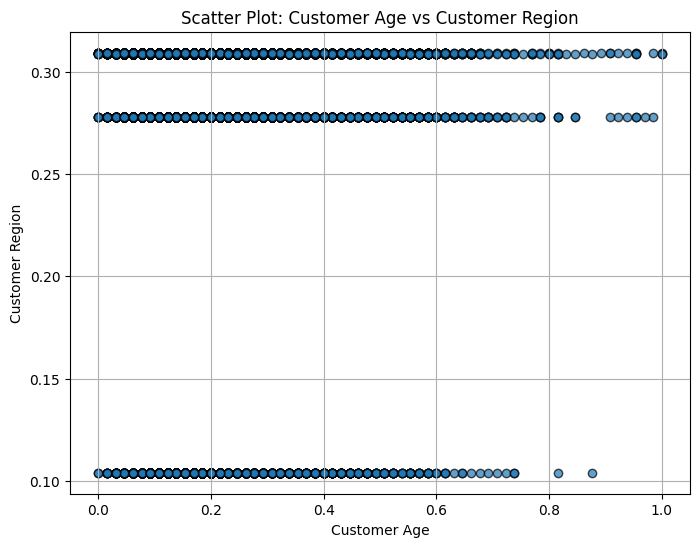

In [624]:
plt.figure(figsize=(8, 6))
plt.scatter(df_demo['customer_age'], df_demo['customer_region'], alpha=0.7, edgecolor='k')
plt.title('Scatter Plot: Customer Age vs Customer Region')
plt.xlabel('Customer Age')
plt.ylabel('Customer Region')
plt.grid(True)
plt.show()

In [625]:
df_demo.to_csv('df_demo.csv')

# PCA analisys

In [626]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30554 entries, 1b8f824d5e to fd40d3b0e0
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vendor_count              30554 non-null  float64
 1   product_count             30554 non-null  float64
 2   is_chain                  30554 non-null  float64
 3   first_order               30554 non-null  float64
 4   last_order                30554 non-null  float64
 5   last_promo                30554 non-null  float64
 6   payment_method            30554 non-null  float64
 7   CUI_American              30554 non-null  float64
 8   CUI_Asian                 30554 non-null  float64
 9   CUI_Beverages             30554 non-null  float64
 10  CUI_Cafe                  30554 non-null  float64
 11  CUI_Chicken Dishes        30554 non-null  float64
 12  CUI_Chinese               30554 non-null  float64
 13  CUI_Desserts              30554 non-null  float64
 1

In [627]:
metric_features = df.select_dtypes(include=['number']).columns.tolist()
X = df[metric_features]
pca = PCA().fit(X)

In [628]:
PCA_s=pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)
PCA_s.head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,0.163602,0.000000,0.362983,0.362983
2,0.085767,-0.077836,0.190289,0.553273
3,0.044428,-0.041339,0.098572,0.651844
4,0.042361,-0.002067,0.093987,0.745831
5,0.030877,-0.011484,0.068507,0.814339
6,0.020730,-0.010147,0.045994,0.860333
7,0.007854,-0.012876,0.017426,0.877758
8,0.004534,-0.003320,0.010060,0.887818
9,0.003644,-0.000890,0.008086,0.895904
10,0.003169,-0.000475,0.007032,0.902936


In [629]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X.columns)
print(loadings)

                            PC1       PC2       PC3       PC4       PC5  \
vendor_count           0.101373  0.006093  0.015066 -0.045140 -0.011691   
product_count          0.093133  0.008199 -0.073074  0.000678 -0.012347   
is_chain               0.065745  0.002753 -0.047603 -0.006434 -0.014317   
first_order           -0.434215  0.694413 -0.097060  0.128335  0.029070   
last_order             0.353736  0.715997  0.140449 -0.168733 -0.039453   
...                         ...       ...       ...       ...       ...   
Intensity_of_Activity  0.170928  0.004517  0.261429 -0.128765  0.004402   
Customer_loyalty      -0.355626 -0.054439  0.778579 -0.351653  0.035988   
product_intensity     -0.008966  0.000342 -0.002536  0.002391  0.011059   
Day_Week_Spread        0.035513  0.002809 -0.030343  0.001391 -0.005646   
hour_spread            0.010133  0.000956 -0.012959  0.001362 -0.002337   

                            PC6       PC7       PC8       PC9      PC10  ...  \
vendor_count       

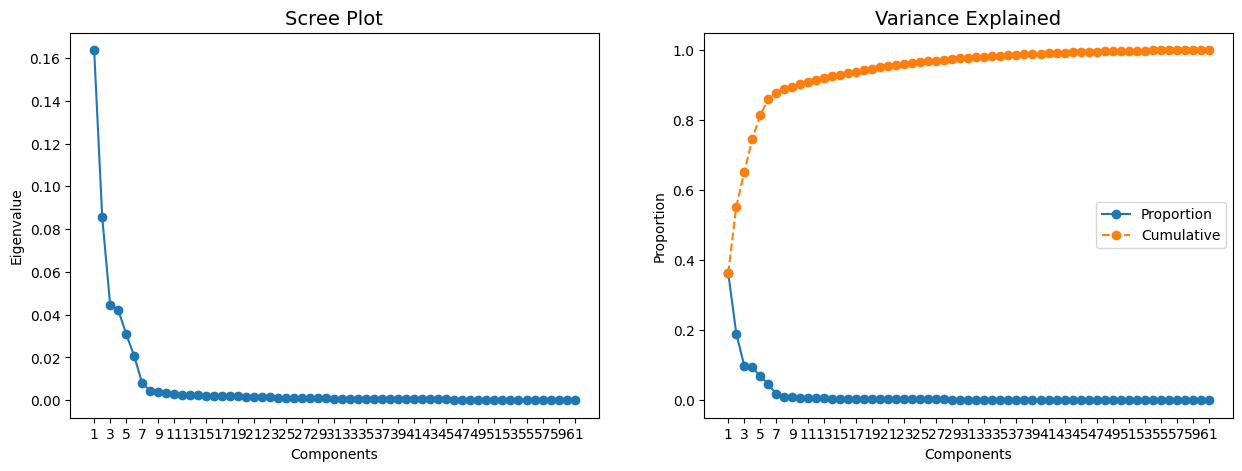

In [630]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

We decided to establish a threshold of 85% cumulative variance, so we will retain the first 6 components

In [631]:
#Retain the first 6 components
pca = PCA(n_components=6)
pca_feat = pca.fit_transform(df[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
#Create the dataframe "df_PCA" with the PC`s and the normalized categorical features
df_PCA = pd.DataFrame(pca_feat, index=df.index, columns=pca_feat_names)
df_PCA=pd.concat([df_PCA,ohc_df],axis=1)
#Normalize the PC features
metric_features1 = df_PCA.select_dtypes(include=['number']).columns.tolist()
scaled_feat = scaler.fit_transform(df_PCA[metric_features1])
df_PCA = scaled_feat
df_PCA = pd.DataFrame(df_PCA, index=df.index, columns=metric_features1)

# Outlier removing using DBSCAN

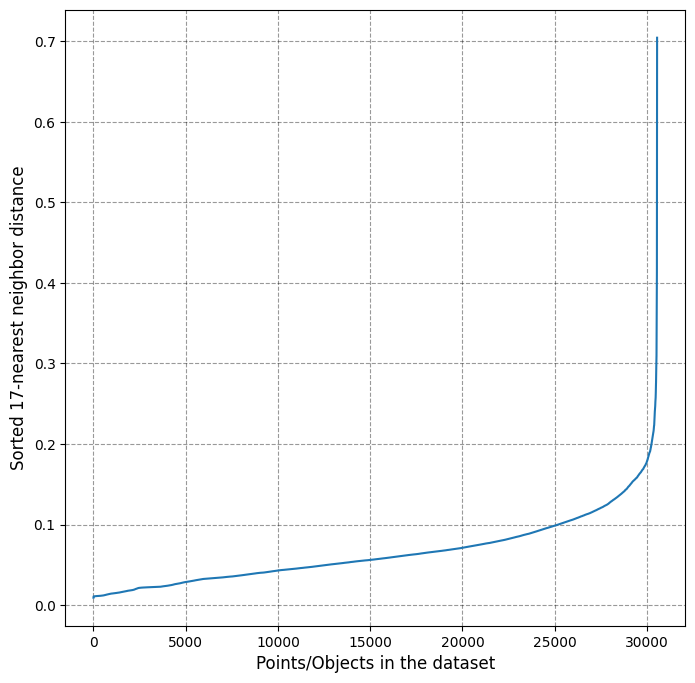

In [632]:
from sklearn.neighbors import NearestNeighbors
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * df_PCA.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=df_PCA, k=k)

In [660]:
from sklearn.cluster import DBSCAN
epsilon = 0.15  
min_samples = 14  
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(df_PCA)

In [661]:
df_PCA['Cluster'] = clusters

In [662]:
df_PCA['Cluster'].value_counts()

Cluster
 11    7049
 8     3160
 3     3043
 14    2697
 1     1938
 6     1835
 2     1724
 7     1461
 10    1450
 4     1100
 13     958
 5      945
 0      747
-1      547
 9      484
 15     474
 12     313
 16     295
 17     201
 19      28
 24      17
 20      16
 18      15
 23      15
 21      14
 22      14
 25      14
Name: count, dtype: int64

In [194]:
df_PCA = df_PCA[df_PCA['Cluster'] != -1].reset_index(drop=True)

In [195]:
df_PCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30041 entries, 0 to 30040
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PC0              30041 non-null  float64
 1   PC1              30041 non-null  float64
 2   PC2              30041 non-null  float64
 3   PC3              30041 non-null  float64
 4   PC4              30041 non-null  float64
 5   PC5              30041 non-null  float64
 6   customer_region  30041 non-null  float64
 7   last_promo       30041 non-null  float64
 8   payment_method   30041 non-null  float64
 9   Cluster          30041 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 2.3 MB


In [196]:
df_PCA.to_csv('df_PCA.csv')